In [1]:
import numpy
import torch
from torchvision import datasets
import torchvision.transforms.v2 as v2
from torch.utils.data import random_split, DataLoader

Load CIFAR-10 dataset

In [13]:
transform = v2.Compose([
    v2.ToTensor()
])

# TODO: Move data prep to its own python script

dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

C:\Users\elias\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Apply the data transformations

In [ ]:
from data_prep import compute_mean_std, compute_min_max, MinMaxScaling

data_mean, data_std = compute_mean_std(dataset)
data_min, data_max = compute_min_max(dataset)

dataset.transform = v2.Compose([
    v2.ToTensor(),
    v2.Normalize(mean=data_mean, std=data_std), # Apply z-score normalization
    MinMaxScaling(data_min, data_max, 0, 1), # Apply min-max scaling to [0,1]

    v2.RandomHorizontalFlip(p=0.5), # add ability to control these parameters later
    v2.RandomCrop((16,16)),
    v2.GaussianNoise(mean=0, sigma=0.1),
    v2.ColorJitter()
])

Split data

In [ ]:
# This custom split is from the official training data and does not use the official testing data
generator = torch.Generator().manual_seed(7)

# Split into training, validation and testing data
train_set, val_set, test_set = random_split(dataset, [0.8, 0.1, 0.1], generator=generator)

# Split into labeled and unlabeled for semi-supervised setup
labeled_training_set, unlabeled_training_set = random_split(train_set, [0.2, 0.8], generator=generator)

# Split into initial training and validation (from the labeled data)
initial_training_set, initial_validation_set = random_split(labeled_training_set, [0.75, 0.25], generator=generator)

Preview the data

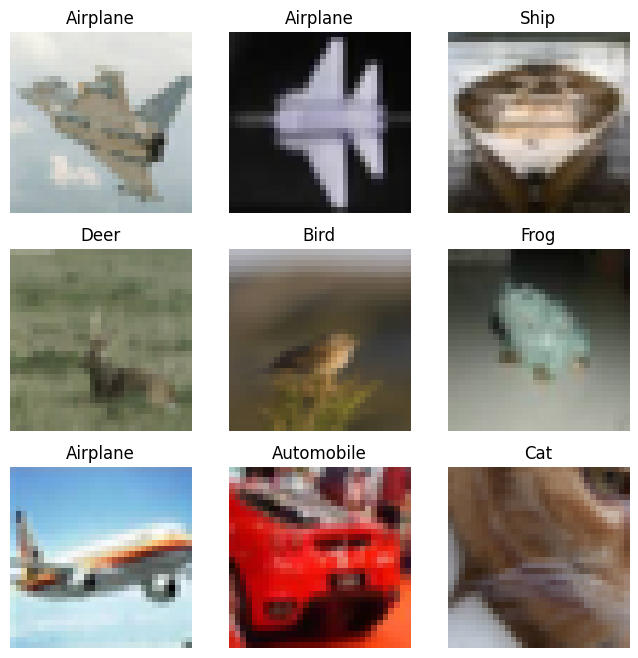

In [18]:
import matplotlib.pyplot as plt

labels = {
    0: "Airplane",
    1: "Automobile",
    2: "Bird",
    3: "Cat",
    4: "Deer",
    5: "Dog",
    6: "Frog",
    7: "Horse",
    8: "Ship",
    9: "Truck"
}

figure = plt.figure(figsize=(8,8))
cols, rows = 3, 3
for i in range(1, cols*rows+1):
    sample_idx = torch.randint(len(dataset), size=(1,)).item()
    img, label = dataset[sample_idx]
    figure.add_subplot(rows,cols,i)
    plt.title(labels[label])
    plt.axis("off")
    img = img.permute(1,2,0)
    plt.imshow(img.squeeze(), cmap="viridis")
plt.show()

Create data loaders

In [19]:
initial_train_loader = DataLoader(initial_training_set, batch_size=64, shuffle=True)
initial_val_loader = DataLoader(initial_validation_set, batch_size=64)
test_loader = DataLoader(test_set, batch_size=64)

Configure supervised neural network, optimizer and loss function

In [ ]:
from model_supervised import SupervisedNetwork
import torch.nn as nn
import torch.optim as optim

# TODO: add more parameter options
lr = 0.01
momentum = 0.9

model = SupervisedNetwork()
#apply weight initialization here

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

Train supervised neural network

In [ ]:
epochs = 10

for epoch in range(epochs):
    model.train()
    training_loss = 0.0
    correct = 0
    total = 0

    # Training loop
    for images, labels in initial_train_loader:

        optimizer.zero_grad() # zero gradients

        outputs = model(images)  # forward pass
        loss = criterion(outputs, labels)

        loss.backward() # backpropigate error
        optimizer.step() # update parameters

        training_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    training_loss /= total
    train_acc = correct / total

    print(
        f"Epoch [{epoch+1}/{epochs}] | "
        f"Train Loss: {training_loss:.4f}, Train Accuracy: {train_acc:.4f}"
    )

Epoch [1/10] | Train Loss: 1.9495, Train Accuracy: 0.2770
Epoch [2/10] | Train Loss: 1.6560, Train Accuracy: 0.3772
Epoch [3/10] | Train Loss: 1.5535, Train Accuracy: 0.4298
Epoch [4/10] | Train Loss: 1.4378, Train Accuracy: 0.4670
Epoch [5/10] | Train Loss: 1.3558, Train Accuracy: 0.4968
Epoch [6/10] | Train Loss: 1.2381, Train Accuracy: 0.5365
Epoch [7/10] | Train Loss: 1.2328, Train Accuracy: 0.5503
Epoch [8/10] | Train Loss: 1.0837, Train Accuracy: 0.6088
Epoch [9/10] | Train Loss: 1.0517, Train Accuracy: 0.6195
Epoch [10/10] | Train Loss: 0.9690, Train Accuracy: 0.6488
